In [1]:
# tep 1: 환경 확인 및 정리
import sys
print("Python 버전:", sys.version)

# 기존 torch 관련 모듈 정리
import importlib
import sys
modules_to_remove = [mod for mod in sys.modules if 'torch' in mod]
for mod in modules_to_remove:
    if mod in sys.modules:
        del sys.modules[mod]

print("모듈 캐시 정리 완료")

Python 버전: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
모듈 캐시 정리 완료


In [2]:
# 라이브러리 재설치
!pip uninstall torch torchvision -y
!pip install torch torchvision --no-cache-dir

print("PyTorch 재설치 완료")

Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 181.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 204.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 169.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 202.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 366.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 125.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 111.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6

In [3]:
from __future__ import print_function
import torch
import torch.nn as nnz
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets, transforms
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import Image, display


모든 라이브러리 import 성공


In [4]:
# 기본 설정
class Config:
    batch_size = 128
    epochs = 5  # 처음에는 5 epoch로 테스트
    seed = 42
    log_interval = 100

config = Config()

# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# 시드 설정
torch.manual_seed(config.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(config.seed)

# 결과 폴더 생성
os.makedirs('results', exist_ok=True)
print("초기 설정 완료")

Device: cuda
초기 설정 완료


In [5]:
# 데이터 로더 (원본 코드 기반)
print("📁 MNIST 데이터셋 준비 중...")

kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,  # 원본: '../data' → './data'
                   transform=transforms.ToTensor()),
    batch_size=config.batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=config.batch_size, shuffle=False, **kwargs)

print(f"✅ 학습 데이터: {len(train_loader.dataset):,}개")
print(f"✅ 테스트 데이터: {len(test_loader.dataset):,}개")
print(f"✅ 배치 크기: {config.batch_size}")

📁 MNIST 데이터셋 준비 중...


100%|██████████| 9.91M/9.91M [00:00<00:00, 14.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 495kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.7MB/s]


✅ 학습 데이터: 60,000개
✅ 테스트 데이터: 10,000개
✅ 배치 크기: 128


In [6]:
# VAE 모델 클래스
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

print("VAE 클래스 정의 완료")

VAE 클래스 정의 완료


In [7]:
# 모델 및 옵티마이저 생성 (
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(f"VAE 모델 생성 완료!")
print(f"총 파라미터 수: {sum(p.numel() for p in model.parameters()):,}")
print(f"잠재 차원: 20")
print(f"옵티마이저: Adam (lr=0.001)")

VAE 모델 생성 완료!
총 파라미터 수: 652,824
잠재 차원: 20
옵티마이저: Adam (lr=0.001)


In [8]:
# 손실 함수 (
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

print("손실 함수 정의 완료!")
print("손실 = BCE (재구성 손실) + KLD (KL 발산)")

손실 함수 정의 완료!
손실 = BCE (재구성 손실) + KLD (KL 발산)


In [9]:
# 학습 함수
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        # 로그 출력
        if batch_idx % config.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

print("학습 함수 정의 완료")

학습 함수 정의 완료


In [10]:
# 테스트 함수
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(config.batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

print("테스트 함수 정의 완료")

테스트 함수 정의 완료


In [11]:
# 코랩용 시각화 함수
def show_results(epoch):
    """코랩에서 결과 이미지 바로 표시"""
    from IPython.display import Image, display

    # 재구성 결과 표시
    recon_path = f'results/reconstruction_{epoch}.png'
    if os.path.exists(recon_path):
        print(f"Epoch {epoch} - 재구성 결과 (원본 vs 재구성):")
        display(Image(recon_path))

    # 생성 결과 표시
    sample_path = f'results/sample_{epoch}.png'
    if os.path.exists(sample_path):
        print(f"Epoch {epoch} - 랜덤 생성 결과:")
        display(Image(sample_path))

print("시각화 함수 정의 완료")

시각화 함수 정의 완료


VAE 학습 시작
설정: 5 epochs, 배치 128, 잠재차원 20
------------------------------------------------------------

Epoch 1/5
Train Epoch: 1 [0/60000 (0%)]	Loss: 105.714828
Train Epoch: 1 [12800/60000 (21%)]	Loss: 107.258080
Train Epoch: 1 [25600/60000 (43%)]	Loss: 109.103134
Train Epoch: 1 [38400/60000 (64%)]	Loss: 108.140892
Train Epoch: 1 [51200/60000 (85%)]	Loss: 111.011787
====> Epoch: 1 Average loss: 108.7139
====> Test set loss: 107.5732
Epoch 1 - 재구성 결과 (원본 vs 재구성):


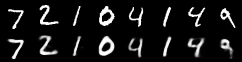

Epoch 1 - 랜덤 생성 결과:


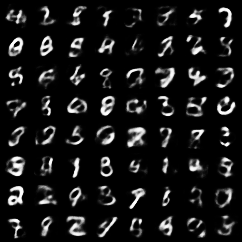

------------------------------------------------------------

Epoch 2/5
Train Epoch: 2 [0/60000 (0%)]	Loss: 105.765335
Train Epoch: 2 [12800/60000 (21%)]	Loss: 109.590118
Train Epoch: 2 [25600/60000 (43%)]	Loss: 109.313080
Train Epoch: 2 [38400/60000 (64%)]	Loss: 108.674950
Train Epoch: 2 [51200/60000 (85%)]	Loss: 105.253662
====> Epoch: 2 Average loss: 107.8222
====> Test set loss: 106.9218
Epoch 2 - 재구성 결과 (원본 vs 재구성):


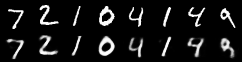

Epoch 2 - 랜덤 생성 결과:


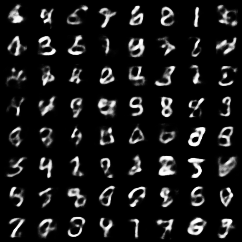

------------------------------------------------------------

Epoch 3/5
Train Epoch: 3 [0/60000 (0%)]	Loss: 105.347610
Train Epoch: 3 [12800/60000 (21%)]	Loss: 108.606827
Train Epoch: 3 [25600/60000 (43%)]	Loss: 111.133499
Train Epoch: 3 [38400/60000 (64%)]	Loss: 106.734459
Train Epoch: 3 [51200/60000 (85%)]	Loss: 108.859253
====> Epoch: 3 Average loss: 107.1558
====> Test set loss: 106.4816
Epoch 3 - 재구성 결과 (원본 vs 재구성):


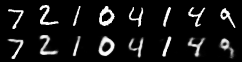

Epoch 3 - 랜덤 생성 결과:


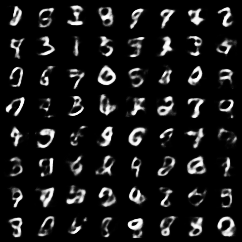

------------------------------------------------------------

Epoch 4/5
Train Epoch: 4 [0/60000 (0%)]	Loss: 107.485939
Train Epoch: 4 [12800/60000 (21%)]	Loss: 110.680496
Train Epoch: 4 [25600/60000 (43%)]	Loss: 110.517982
Train Epoch: 4 [38400/60000 (64%)]	Loss: 106.655243
Train Epoch: 4 [51200/60000 (85%)]	Loss: 104.823883
====> Epoch: 4 Average loss: 106.6177
====> Test set loss: 106.0669
Epoch 4 - 재구성 결과 (원본 vs 재구성):


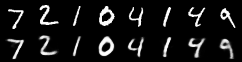

Epoch 4 - 랜덤 생성 결과:


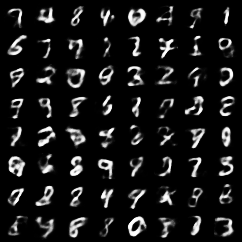

------------------------------------------------------------

Epoch 5/5
Train Epoch: 5 [0/60000 (0%)]	Loss: 104.798080
Train Epoch: 5 [12800/60000 (21%)]	Loss: 98.947128
Train Epoch: 5 [25600/60000 (43%)]	Loss: 106.278450
Train Epoch: 5 [38400/60000 (64%)]	Loss: 105.362152
Train Epoch: 5 [51200/60000 (85%)]	Loss: 102.576599
====> Epoch: 5 Average loss: 106.2028
====> Test set loss: 105.6208
Epoch 5 - 재구성 결과 (원본 vs 재구성):


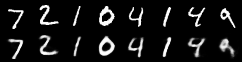

Epoch 5 - 랜덤 생성 결과:


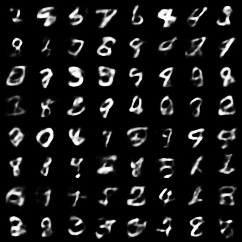

------------------------------------------------------------
학습 완료!


In [13]:
# 메인 학습 루프
print(f"VAE 학습 시작")
print(f"설정: {config.epochs} epochs, 배치 {config.batch_size}, 잠재차원 20")
print("-" * 60)

for epoch in range(1, config.epochs + 1):
    print(f"\nEpoch {epoch}/{config.epochs}")

    # 학습 (원본 그대로)
    train(epoch)

    # 테스트 (원본 그대로)
    test(epoch)

    # 랜덤 생성 (원본 그대로)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')

    # 코랩에서 결과 확인 (추가)
    show_results(epoch)
    print("-" * 60)

print("학습 완료!")

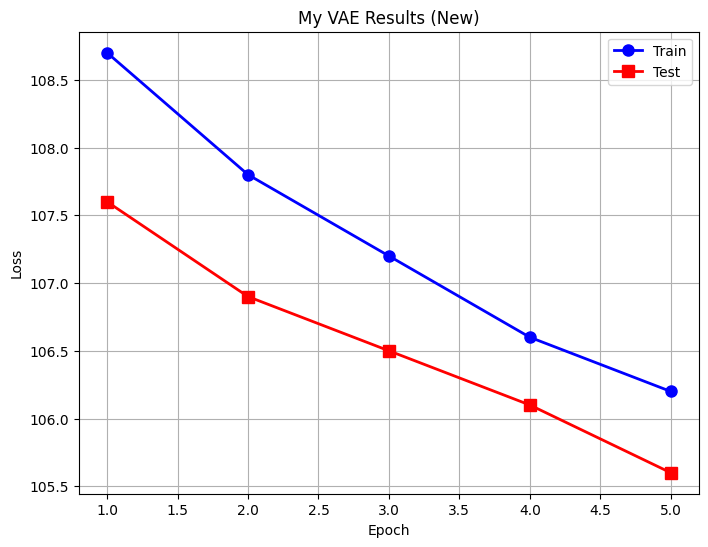

 간단 요약:
시작: Train 108.7, Test 107.6
끝:   Train 106.2, Test 105.6


In [14]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5]
train_loss = [108.7, 107.8, 107.2, 106.6, 106.2]
test_loss = [107.6, 106.9, 106.5, 106.1, 105.6]

# 그래프
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, 'b-o', label='Train', linewidth=2, markersize=8)
plt.plot(epochs, test_loss, 'r-s', label='Test', linewidth=2, markersize=8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('My VAE Results (New)')
plt.legend()
plt.grid(True)
plt.show()

print(" 요약:")
print(f"시작: Train {train_loss[0]:.1f}, Test {test_loss[0]:.1f}")
print(f"끝:   Train {train_loss[-1]:.1f}, Test {test_loss[-1]:.1f}")